In [1]:
from decimal import Decimal
import json
from decimal import InvalidOperation

objs = []
root = '/Users/rivers/Desktop/nice datasets/MOBA/'
data_root = root+'matches/'
save_root = root+'Topics/Bursty/intermediate/'
graph_root = root+'Topics/Bursty/results/'
game_mode = -1

mode_dict = {-1: 'captainrank', 22: 'rank',1:'allpick',5:'allrandom'}

In [2]:
def decimal_decoder(obj):
    for key, value in obj.items():
        if isinstance(value, str):  # Ensure the value is a string
            try:
                # Attempt to convert strings that look like Decimals back to Decimal objects
                obj[key] = Decimal(value)
            except InvalidOperation:
                pass  # Skip conversion if the value cannot be converted to Decimal
    return obj

def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

def chats_of(slot,chat):
    t = []
    l = []
    for chat_line in chat:
        #print(chat_line)
        if 'slot' in list(chat_line.keys()):
            if chat_line['slot'] == slot:
                t.append(chat_line['time'])
                l.append(len(str(chat_line['key'])))
    if len(t) > 1:
        t_diff = calculate_differences(t)
        t_diff.insert(0,0)
    
        return l, t_diff
    else:
        return [],[]


In [3]:
import numpy as np
modes = list(mode_dict.keys())
slots = list(range(10))

team_t, team_l, ind_t, ind_l, pois_ts, lambs= {}, {}, {}, {}, {}, {}

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)

        
    team_t_sample, team_l_sample, ind_t_sample, ind_l_sample, pois_t = [], [], [], [], []
    for obj in objs:
        if (mode == 2 and obj['lobby_type'] == 7) or mode != 2:
            time = []
            if len(obj['chat']) > 1:
                for chat_line in obj['chat']:
                    time.append(chat_line['time'])
                    
                    team_l_sample.append(len(str(chat_line['key'])))
                
                diff = calculate_differences(time)
                diff.insert(0,0)
                team_t_sample += diff
            
            for slot in slots:
                l, t_diff = chats_of(slot, obj['chat'])
                ind_t_sample += t_diff
                ind_l_sample += l
        if len(obj['chat'])>0 and obj['chat'][0]['time']>0:
            ini_t = obj['chat'][0]['time']
            pois_t.append(ini_t)
    pois_ts[mode] = pois_t
    lambs[mode] = 1/np.mean(pois_t)
    team_t[mode], team_l[mode], ind_l[mode], ind_t[mode] = team_t_sample, team_l_sample, ind_l_sample, ind_t_sample

In [48]:
t = 20
K = 30
tau_1 = 7
rang = (300,2500)

save = False
upper_thres = 5000

current mode:  captainrank
best tau_0 =  531.578947368421


/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_89588/2187500605.py:23: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-beta * x)


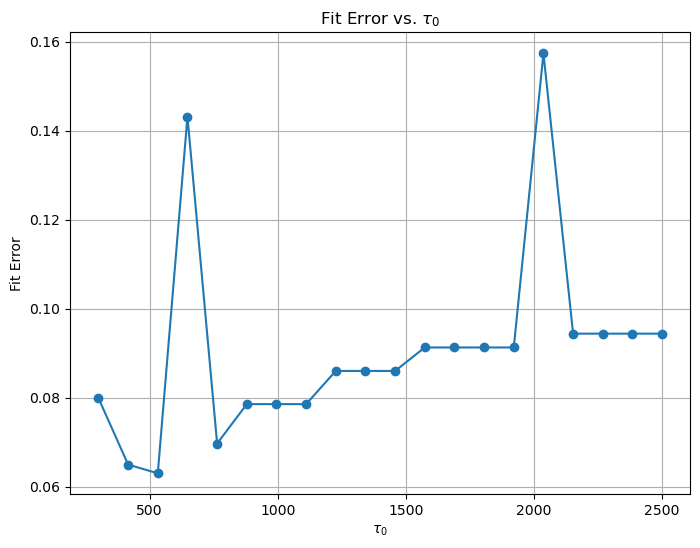

exp_x range: min=634.0707003050528, max=4940.000000000002
beta:  0.0013054009032614506
Fitted A: 0.0007753674035037776, Fitted beta: 0.0013054009032614506
p1 = 0.4021363625421952


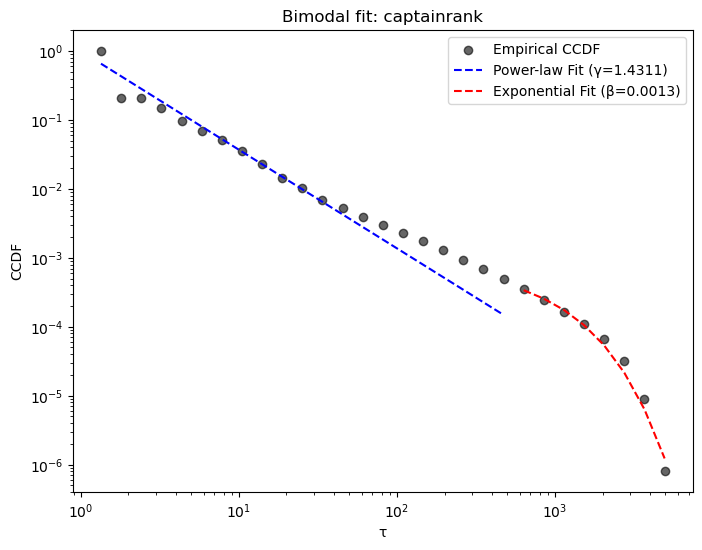

Best Fit Error: 0.0630
current mode:  rank
best tau_0 =  647.3684210526316


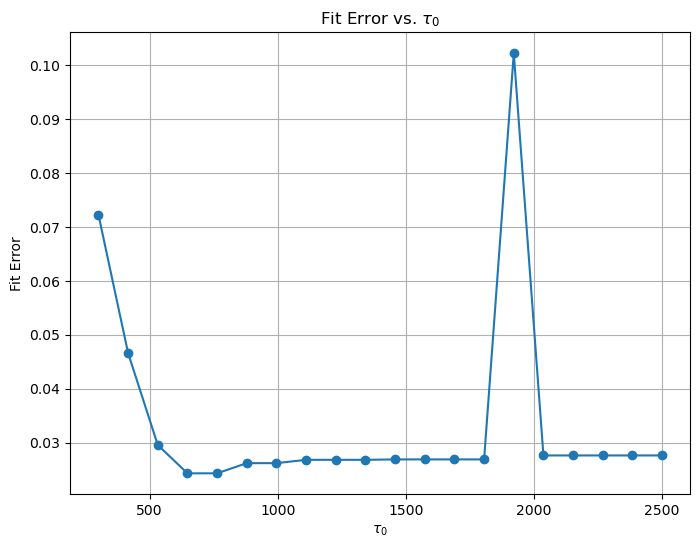

exp_x range: min=799.2675087047937, max=4570.000000000002
beta:  0.0015681026936341944
Fitted A: 0.0010717832890219925, Fitted beta: 0.0015681026936341944
p1 = 0.056242092315222925


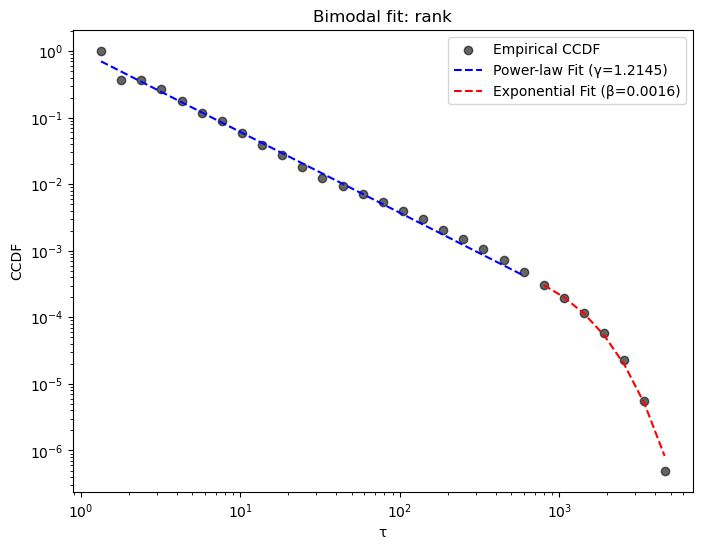

Best Fit Error: 0.0244
current mode:  allpick
best tau_0 =  647.3684210526316


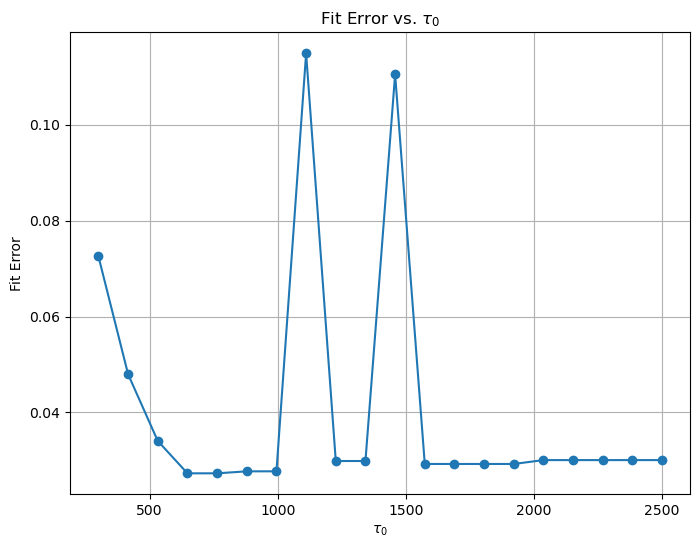

exp_x range: min=824.1350409185255, max=4749.999999999997
beta:  0.001499913382483828
Fitted A: 0.0011240577425077319, Fitted beta: 0.001499913382483828
p1 = 0.2652163046225229


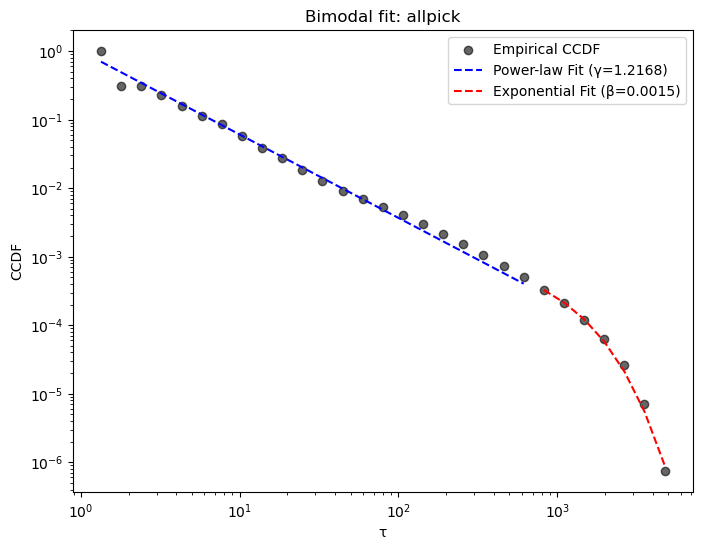

Best Fit Error: 0.0273
current mode:  allrandom
best tau_0 =  531.578947368421


/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_89588/2187500605.py:79: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y, p0=[1, 0.01])


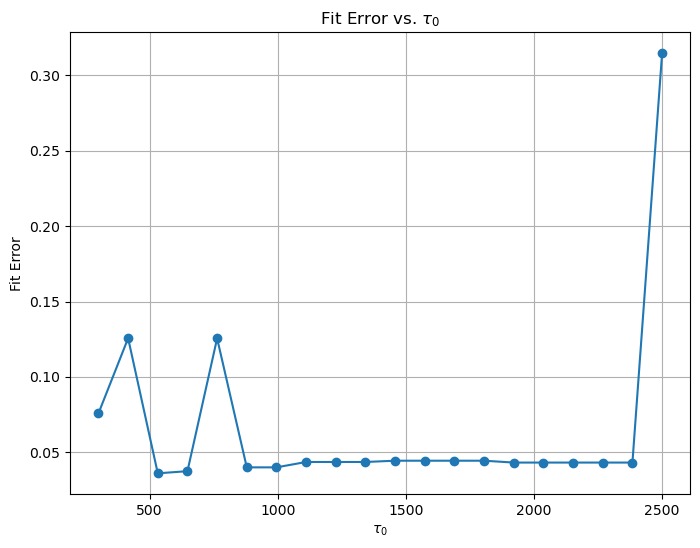

exp_x range: min=581.6634824473296, max=4408.999999999998
beta:  0.0015526835430870404
Fitted A: 0.0012589336326889326, Fitted beta: 0.0015526835430870404
p1 = 0.5353292040866069


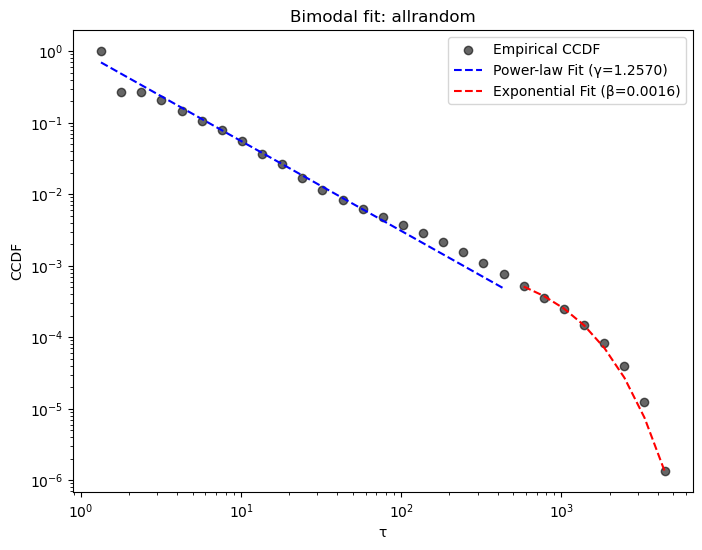

Best Fit Error: 0.0361


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def add1(lst):
    return [x + 1 for x in lst]

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def power_law(x, gamma):
    return x ** -gamma

def exponential(x, A, beta):
    return A * np.exp(-beta * x)
    
def safe_exponential(x, A, beta):
    x = x / np.max(x)  # Rescale x
    return A * np.exp(-beta * x)

def compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K):
    # Compute model CCDF
    model_ccdf = np.piecewise(
        x_vals,
        [x_vals < tau_0 - t, x_vals > tau_0 + t],
        [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
    )
    
    # Ensure numerical stability
    ccdf_vals = np.where(ccdf_vals <= 0, 1e-10, ccdf_vals)
    model_ccdf = np.where(model_ccdf <= 0, 1e-10, model_ccdf)
    
    # Select K bins for error calculation

    num, denom = 0, 0
    # Compute error function based on the given formula

    indices = np.linspace(0, len(x_vals) - 1, K, dtype=int)
    ccdf_vals_k = ccdf_vals[indices]
    model_ccdf_k = model_ccdf[indices]

    num = np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
    denom = np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
    
    # Avoid division by zero
    if denom == 0:
        return np.nan  # Assign NaN if denominator is zero
    
    error = 2 * num / denom
    return error


def fit_bimodal(data, tau_0, tau_1, t, K):
    data = np.array(data)  # Ensure data is a NumPy array

    # Compute empirical CCDF
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    #print(bins)
    x_vals, ccdf_vals = empirical_ccdf(data, bins)

    # Fit power-law
    pl_x = x_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    pl_y = ccdf_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    popt_pl, _ = curve_fit(lambda x, gamma: power_law(x, gamma), pl_x, pl_y, p0=[1.5])

    # Fit exponential
    exp_x = x_vals[(x_vals > tau_0 + t) & (x_vals <= upper_thres)]
    exp_y = ccdf_vals[x_vals > tau_0 + t]
    
    if len(exp_x) > 0 and len(exp_y) > 0:
        popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y, p0=[1, 0.01])
    else:
        print("Warning: No valid exponential data. Adjust τ₀ or t.")
        popt_exp = [np.nan, np.nan]  # Placeholder for failed fit
    
    return x_vals, ccdf_vals, popt_pl[0], popt_exp  # Ensure popt_exp is returned

def plot_ccdf(data, x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, mode):
    plt.figure(figsize=(8,6))
    
    # Empirical CCDF
    plt.scatter(x_vals, ccdf_vals, label='Empirical CCDF', color='black', alpha=0.6)
    
    # Fitted power-law
    pl_x = x_vals[x_vals < tau_0 - t]
    plt.plot(pl_x, power_law(pl_x, gamma), linestyle='dashed', color='blue', label=f'Power-law Fit (γ={gamma:.4f})')
    
    # Fitted exponential
    exp_x = x_vals[(x_vals > tau_0 + t) & (x_vals <= upper_thres)]
    print(f"exp_x range: min={np.min(exp_x)}, max={np.max(exp_x)}")
    # print(f"exp_y range: min={np.min(exp_y)}, max={np.max(exp_y)}")
    if not np.isnan(popt_exp[0]):  # Check if fitting was successful
        plt.plot(exp_x, exponential(exp_x, *popt_exp), linestyle='dashed', color='red', label=f'Exponential Fit (β={popt_exp[1]:.4f})')
    print('beta: ', popt_exp[1])
    beta = popt_exp[1]
    print(f"Fitted A: {popt_exp[0]}, Fitted beta: {popt_exp[1]}")
    print('p1 =',(beta/lambs[mode])-1)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('CCDF')
    plt.legend()
    plt.title('Bimodal fit: '+ mode_dict[mode])
    if save:
        plt.savefig(graph_root+'/bimodal/fitted_%s.pdf'%str(mode_dict[mode]))
    plt.show()


def find_best_tau0(data, rang,tau_1, t, K):
    tau0_values = np.linspace(rang[0], rang[1], 20)
    e_lst = []
    
    for tau_0 in tau0_values:
        x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
        error = compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K)
        # error = compute_error(data, tau_0, tau_1, t, K)
        e_lst.append(error)

    best_tau0 = tau0_values[np.nanargmin(e_lst)]  # Find tau_0 with the minimum error
    return best_tau0, tau0_values, e_lst

for mode in modes:
    print('current mode: ', mode_dict[mode])
    data = np.array(add1(ind_t[mode]))
    best_tau0, tau0_values, e_lst = find_best_tau0(data,rang,tau_1,t,K)
    tau_0 = best_tau0

      # Ensure numeric conversion
    # best_tau0, tau0_values, e_lst = find_best_tau0(data, tau_1, t, K)
    print('best tau_0 = ', best_tau0)


    # Plot error vs tau_0
    plt.figure(figsize=(8, 6))
    plt.plot(tau0_values, e_lst, marker='o', linestyle='-')
    plt.xlabel(r'$\tau_0$')
    plt.ylabel('Fit Error')
    plt.title(r'Fit Error vs. $\tau_0$')
    plt.grid(True)
    if save:
        plt.savefig(graph_root+'/bimodal/E_tau_%s.pdf'%str(mode_dict[mode]))
    plt.show()
    # print(e_lst)
    # print(tau_0)
    x_vals, ccdf_vals, gamma, beta = fit_bimodal(data, tau_0, tau_1, t, K)
    error = compute_error(x_vals, ccdf_vals, gamma, beta, tau_0, t, K)
    plot_ccdf(data, x_vals, ccdf_vals, gamma, beta, tau_0, t,mode)

    print(f'Best Fit Error: {error:.4f}')